<a href="https://colab.research.google.com/github/KyungdaePark/HongongMachine/blob/master/Cross_Validate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 교차 검증, 훈련/테스트 세트로 나눈 뒤 훈련 세트를 한번 더 훈련/검증 세트로 나누는것
# 여기서는 훈련 80 테스트 20 에서 훈련의 훈련 80 훈련의 검증 20으로 나눔
# 훈련 64 검증 16 테스트 20으로 나눔

# 이걸 왜 하냐, 가장 최적의 모델을 구하기 위해서, dt에서 언제까지 max_depth를 하나하나 설정하고, classifier의 매개변수를 모두 다 한번씩 해볼 순 없기 때문
import pandas as pd
wine = pd.read_csv('http://bit.ly/wine_csv_data')
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine[['class']].to_numpy()

from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size = 0.2, random_state = 42
)

In [ ]:
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size = 0.2, random_state = 42
)

In [ ]:
print(sub_input.shape, val_input.shape)

(4157, 3) (1040, 3)


In [ ]:
# sub는 4157개 val은 1040개 
# 이제 dt 평가
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 42)
dt.fit(sub_input, sub_target)
print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

0.9971133028626413
0.864423076923077


In [ ]:
# 훈련 세트에 overfitted
# 교차검증(cross validation 을 해보자. 이건 훈련 세트 中 검증 세트를 모든 경우의 수로 정해 검증한다. p.245)
# 5-fold cross validation, cross_validation()
from sklearn.model_selection import cross_validate
time_and_score = cross_validate(dt, train_input, train_target)
print(time_and_score)


{'fit_time': array([0.01109457, 0.00708532, 0.00742269, 0.00834131, 0.00721145]), 'score_time': array([0.00083947, 0.00073218, 0.00080037, 0.00080872, 0.00077844]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


In [ ]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(dt, train_input, train_target)
print(score)

[0.86923077 0.84615385 0.87680462 0.84889317 0.83541867]


In [ ]:
# 기본으로 5-fold cross validate
import numpy as np
print(np.mean(time_and_score['test_score']))

0.855300214703487


In [ ]:
# 근데 애는 안섞고 그냥 5조각으로 나눠서함. 그래서 분할기 (splitter)가 필요함
# 회귀모델이면 KFold 분류 모델이면 StratifiedKFold 함수 用, 이 코드는 위 코드랑 같은거 ( 노 셔플 )
from sklearn.model_selection import StratifiedKFold 
scores = cross_validate(dt, train_input, train_target, cv = StratifiedKFold())
print(np.mean(scores['test_score']))

0.855300214703487


In [ ]:
print(scores['test_score'])

[0.86923077 0.84615385 0.87680462 0.84889317 0.83541867]


In [ ]:
# 10-fold cv?
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state =42)
scores2 = cross_validate(dt,train_input, train_target, cv=splitter)
print(scores2)

{'fit_time': array([0.01598477, 0.00865173, 0.00904918, 0.00875187, 0.00986719,
       0.0086937 , 0.00825453, 0.00831485, 0.00821471, 0.00885701]), 'score_time': array([0.00125742, 0.00081182, 0.00080824, 0.00074577, 0.00132751,
       0.0007391 , 0.00070572, 0.00070906, 0.00072622, 0.0007596 ]), 'test_score': array([0.83461538, 0.87884615, 0.85384615, 0.85384615, 0.84615385,
       0.87307692, 0.85961538, 0.85549133, 0.85163776, 0.86705202])}


In [ ]:
print(np.mean(scores2['test_score']))

0.8574181117533719


In [ ]:
# 그럼 이제 cross validate(교차 검증)을 통해서 최적의 모델을 찾아보자

# 하이퍼파라미터 튜닝 : 매개변수를 튜닝
# 근데 매개변수가 2개이상이면? A 와 B params를 동시에 바꿔가면서 해야하는데 for문을 이용해야 함
# 근데 for문 할 필요 없이 이를 대신 해주는 도구가 있음 : GridSearchCV
# 또 cross_validate()를 호출할 필요도 없음

# dt에서 min_impurity_decrease 매개변수의 최적값을 찾아보자

from sklearn.model_selection import GridSearchCV
params = {'min_impurity_decrease' : [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}
gs = GridSearchCV(DecisionTreeClassifier(random_state = 42), params, n_jobs=-1)
# 1. GridSearchCV는 기본적으로 Cross Validate 를 5번 실행함(cv=5)
# 2. 그리고 여기에서 params가 5개 있음
# 3. 즉, #1 * #2 = 25번 반복함. 이때 활동하는 cpu코어의 수는 n_jobs, n_jobs = -1이면 cpu의 모든 코어 사용

gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

In [ ]:
# 이중에서 최고의 모델은 best_estimator_에 있음
print(gs.best_estimator_)

DecisionTreeClassifier(min_impurity_decrease=0.0001, random_state=42)


In [ ]:
dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.9615162593804117


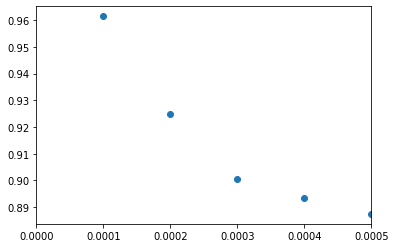

In [ ]:
# 혼자 해보는거, 진짜 맞는지 그래프로 그려보자

par = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]
scores = []
for i in range(0,5):
  dt2 = DecisionTreeClassifier(random_state =42, min_impurity_decrease = par[i])
  dt2.fit(train_input, train_target)
  scores.append(dt2.score(train_input, train_target))

import matplotlib.pyplot as plt
plt.scatter(par,scores)
plt.xlim(0,0.0005)
plt.show()

In [ ]:
print(gs.best_params_)

{'min_impurity_decrease': 0.0001}


In [ ]:
print(gs.cv_results_['mean_test_score'])

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [ ]:
#min_impurity_decrease 가 각각 10^(-4) * (1,2,3,4,5)일 경우 5-fold cv의 결과

best_index = np.argmax(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.0001}


In [ ]:
#1. 검증세트를 분류한다. 검증세트는 훈련세트의 20%
#2. 근데 이 검증세트를 정하는 방식을 여러번 반복한다. K-fold Cross Validate, cross_validate()함수가 해줌
#3. 하이퍼파라미터(=사용자 지정 파라미터)를 이용해 최적의 모델을 찾고 싶다. 이럴 때는 GridSearch를 이용한다.
#   GridSearch는 기본값(5)만큼 교차 검증을 하고, 정해준 params(여기서는 min_impurity_decrease) 개수만큼 각자의 교차 검증에 파라미터를 대입해 보며
#   가장 적합한 모델의 정보를 best_estimator_ 변수에 저장한다.

params = {'min_impurity_decrease' : np.arange(0.0001, 0.001, 0.0001),
          'max_depth' : range(5,20,1),
          'min_samples_split' : range(2,100,10)
          }
          # np.arange : 0.0001, 0.0002 ... 0.0009
          # range(a,b,c) : a,a+c,a+2c ...b-1 ==> (5,20,1) : 5, 6, 7 ... 19

          # 그래서 총 교차 검증 횟수 : 9 * 15 * 10 * 5(K-FoldCV) = 6750

gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [ ]:
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


In [ ]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


In [ ]:
print(gs.best_estimator_)

DecisionTreeClassifier(max_depth=14, min_impurity_decrease=0.0004,
                       min_samples_split=12, random_state=42)


In [ ]:
# 간격을 어떻게 하나. -> 랜덤 서치(Random Search)
# RS에는 매개변수 값의 목록을 전달하지 않고 매개변수를 샘플링 할 수 있는 확률분포객체를 전달함
from scipy.stats import uniform, randint
#randint는 정수값을 뽑고 uniform은 실숫값을 뽑음

rgen = randint(0,10)
rgen.rvs(10)

array([9, 3, 3, 0, 0, 3, 5, 5, 1, 5])

In [ ]:
np.unique(rgen.rvs(1000), return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 79, 110,  98, 108,  95,  81, 107, 109, 105, 108]))

In [ ]:
np.unique(rgen.rvs(1000))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
ugen = uniform(0,1)
ugen.rvs(10)

array([0.34354446, 0.14540471, 0.51015308, 0.13291245, 0.23278927,
       0.98470034, 0.26452305, 0.45290359, 0.67623911, 0.20767313])

In [ ]:
# 난수 발생기 ? 근데 좀 골고루 난수를 발생시킴

# min_samples_leaf : 어떤 노드가 분할하여 만들어질 자식 노드의 샘플 수가 이 값보다 작으면 분할하지 않음

params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth' : randint(20,50),
          'min_samples_split' : randint(2,25),
          'min_samples_leaf' : randint(1,25),
          }

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
gs = RandomizedSearchCV(DecisionTreeClassifier(random_state = 42), params, n_iter=100, n_jobs = -1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7938e75b90>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7938e755d0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7938e75810>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7938e75390>},
                   random_state=42)

In [ ]:
print(gs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [ ]:
print(np.max(gs.cv_results_['mean_test_score'])) # 최고의 교차 검증 점수 (CV score)

0.8695428296438884


In [ ]:
dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.8928227823744468


In [ ]:
print(dt.score(test_input, test_target))

0.86
